# Exploring GAN Variants for Balancing Imbalanced Datasets

Dataset: **card_transdata.csv** (fraud detection)

This notebook implements **Vanilla GAN + two variants (WGAN-GP, LSGAN)** for tabular minority-class generation.
It then balances the training set and evaluates a downstream classifier as required in the project instructions.

In [2]:
DATA_PATH = "/content/card_transdata.csv"


## 0) Setup

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

torch.set_num_threads(2)

DATA_PATH = "card_transdata.csv"
SAMPLE_SIZE = 20000
RANDOM_STATE = 42


## 1) Load data + imbalance visualization

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


Shape: (1000000, 8)
fraud
0.0    912597
1.0     87403
Name: count, dtype: int64


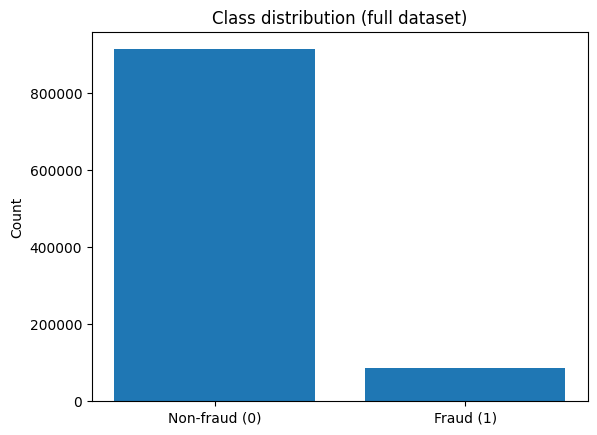

In [4]:
df = pd.read_csv(DATA_PATH)
display(df.head())
print("Shape:", df.shape)
print(df['fraud'].value_counts())

counts_full = df['fraud'].value_counts().sort_index()
plt.figure()
plt.bar(["Non-fraud (0)", "Fraud (1)"], counts_full.values)
plt.title("Class distribution (full dataset)")
plt.ylabel("Count")
plt.show()


## 2) Train/test split + scaling ([-1, 1])

In [5]:
X = df.drop(columns=["fraud"]).astype(np.float32)
y = df["fraud"].astype(int).values

if SAMPLE_SIZE is not None:
    idx = np.arange(len(df))
    fraud_idx = idx[y==1]
    non_idx = idx[y==0]
    n_fraud = int(round(SAMPLE_SIZE * (len(fraud_idx)/len(idx))))
    n_non = SAMPLE_SIZE - n_fraud
    rng = np.random.default_rng(RANDOM_STATE)
    sample_idx = np.concatenate([
        rng.choice(fraud_idx, size=n_fraud, replace=False),
        rng.choice(non_idx, size=n_non, replace=False),
    ])
    rng.shuffle(sample_idx)
    X = X.iloc[sample_idx].reset_index(drop=True)
    y = y[sample_idx]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

minor_mask = (y_train == 1)
X_min = X_train_scaled[minor_mask]
X_maj = X_train_scaled[~minor_mask]

print("Train minority:", X_min.shape, "Train majority:", X_maj.shape)


Train minority: (1398, 7) Train majority: (14602, 7)


## 3) GAN models

In [6]:
device = torch.device("cpu")
data_dim = X_min.shape[1]
z_dim = 16

class G(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 32),
            nn.ReLU(),
            nn.Linear(32, data_dim),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z)

class D(nn.Module):
    def __init__(self, sigmoid=True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1)
        )
        self.sigmoid = sigmoid
    def forward(self, x):
        out = self.net(x)
        return torch.sigmoid(out) if self.sigmoid else out


## 4) Train Vanilla GAN / LSGAN / WGAN-GP (minority only)

In [7]:
def train_vanilla(X, epochs=100, batch=128, lr=2e-4, seed=0):
    torch.manual_seed(seed)
    gen, disc = G().to(device), D(sigmoid=True).to(device)
    optG = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
    optD = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
    bce = nn.BCELoss()

    loader = DataLoader(
        TensorDataset(torch.tensor(X, dtype=torch.float32)),
        batch_size=batch, shuffle=True, drop_last=True
    )

    for _ in range(epochs):
        for (real,) in loader:
            real = real.to(device)
            bs = real.size(0)

            z = torch.randn(bs, z_dim, device=device)
            fake = gen(z).detach()
            optD.zero_grad()
            lossD = bce(disc(real), torch.ones(bs, 1, device=device)) +                             bce(disc(fake), torch.zeros(bs, 1, device=device))
            lossD.backward()
            optD.step()

            z = torch.randn(bs, z_dim, device=device)
            optG.zero_grad()
            fake = gen(z)
            lossG = bce(disc(fake), torch.ones(bs, 1, device=device))
            lossG.backward()
            optG.step()

    return gen

def train_lsgan(X, epochs=100, batch=128, lr=2e-4, seed=1):
    torch.manual_seed(seed)
    gen, disc = G().to(device), D(sigmoid=False).to(device)
    optG = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
    optD = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))
    mse = nn.MSELoss()

    loader = DataLoader(
        TensorDataset(torch.tensor(X, dtype=torch.float32)),
        batch_size=batch, shuffle=True, drop_last=True
    )

    for _ in range(epochs):
        for (real,) in loader:
            real = real.to(device)
            bs = real.size(0)

            z = torch.randn(bs, z_dim, device=device)
            fake = gen(z).detach()
            optD.zero_grad()
            lossD = 0.5 * (mse(disc(real), torch.ones(bs, 1, device=device)) +
                           mse(disc(fake), torch.zeros(bs, 1, device=device)))
            lossD.backward()
            optD.step()

            z = torch.randn(bs, z_dim, device=device)
            optG.zero_grad()
            fake = gen(z)
            lossG = 0.5 * mse(disc(fake), torch.ones(bs, 1, device=device))
            lossG.backward()
            optG.step()

    return gen

def grad_penalty(critic, real, fake):
    bs = real.size(0)
    alpha = torch.rand(bs, 1, device=device).expand_as(real)
    inter = alpha * real + (1 - alpha) * fake
    inter.requires_grad_(True)
    out = critic(inter)
    grads = torch.autograd.grad(
        out, inter, grad_outputs=torch.ones_like(out),
        create_graph=True, retain_graph=True
    )[0]
    grads = grads.view(bs, -1)
    return ((grads.norm(2, dim=1) - 1) ** 2).mean()

def train_wgan_gp(X, epochs=50, batch=128, lr=1e-4, lambda_gp=10.0, seed=2):
    torch.manual_seed(seed)
    gen, critic = G().to(device), D(sigmoid=False).to(device)
    optG = optim.Adam(gen.parameters(), lr=lr, betas=(0.0, 0.9))
    optC = optim.Adam(critic.parameters(), lr=lr, betas=(0.0, 0.9))

    loader = DataLoader(
        TensorDataset(torch.tensor(X, dtype=torch.float32)),
        batch_size=batch, shuffle=True, drop_last=True
    )

    for _ in range(epochs):
        for (real,) in loader:
            real = real.to(device)
            bs = real.size(0)


            z = torch.randn(bs, z_dim, device=device)
            fake = gen(z).detach()
            optC.zero_grad()
            lossC = (critic(fake).mean() - critic(real).mean()) +                             lambda_gp * grad_penalty(critic, real, fake)
            lossC.backward()
            optC.step()

            z = torch.randn(bs, z_dim, device=device)
            optG.zero_grad()
            fake = gen(z)
            lossG = -critic(fake).mean()
            lossG.backward()
            optG.step()

    return gen

gen_v = train_vanilla(X_min, epochs=30)
gen_ls = train_lsgan(X_min, epochs=30)
gen_w = train_wgan_gp(X_min, epochs=10)

print("Done training GANs.")


Done training GANs.


## 5) Generate synthetic minority samples + balance training set

In [8]:
feature_names = list(X.columns)
binary_cols = ['repeat_retailer','used_chip','used_pin_number','online_order']
binary_idx = [feature_names.index(c) for c in binary_cols]

cont_cols = ['distance_from_home','distance_from_last_transaction','ratio_to_median_purchase_price']
caps = np.quantile(X_train[cont_cols].values, 0.99, axis=0)

def generate_samples(gen, n, batch=512):
    gen.eval()
    out = []
    with torch.no_grad():
        remaining = n
        while remaining > 0:
            bs = min(batch, remaining)
            z = torch.randn(bs, z_dim, device=device)
            fake = gen(z).cpu().numpy()
            out.append(fake)
            remaining -= bs
    gen.train()
    return np.vstack(out)

def postprocess(fake_scaled):
    fake = scaler.inverse_transform(fake_scaled).astype(np.float32)


    for i, cap in zip([0,1,2], caps):
        fake[:, i] = np.clip(fake[:, i], 0, cap)


    fake[:, binary_idx] = (np.clip(fake[:, binary_idx], 0, 1) >= 0.5).astype(np.float32)
    return fake

need = X_maj.shape[0] - X_min.shape[0]
print("Need synthetic minority samples:", need)

fake_v_raw = postprocess(generate_samples(gen_v, need))
fake_w_raw = postprocess(generate_samples(gen_w, need))
fake_ls_raw = postprocess(generate_samples(gen_ls, need))

print(fake_v_raw.shape, fake_w_raw.shape, fake_ls_raw.shape)


Need synthetic minority samples: 13204
(13204, 7) (13204, 7) (13204, 7)


## 6) Train the same classifier in the required scenarios + evaluate

In [9]:
def eval_classifier(Xtr_scaled, ytr, Xte_scaled, yte):
    clf = LogisticRegression(max_iter=200, n_jobs=1)
    clf.fit(Xtr_scaled, ytr)

    proba = clf.predict_proba(Xte_scaled)[:, 1]
    pred = (proba >= 0.5).astype(int)

    return {
        "accuracy": accuracy_score(yte, pred),
        "precision": precision_score(yte, pred, zero_division=0),
        "recall": recall_score(yte, pred, zero_division=0),
        "f1": f1_score(yte, pred, zero_division=0),
        "auc_roc": roc_auc_score(yte, proba),
        "cm": confusion_matrix(yte, pred),
    }


res_base = eval_classifier(X_train_scaled, y_train, X_test_scaled, y_test)


X_v_aug_raw = np.vstack([X_train.values, fake_v_raw])
y_v_aug = np.concatenate([y_train, np.ones(len(fake_v_raw), dtype=int)])
X_v_aug_scaled = scaler.transform(X_v_aug_raw)
res_v = eval_classifier(X_v_aug_scaled, y_v_aug, X_test_scaled, y_test)

X_w_aug_raw = np.vstack([X_train.values, fake_w_raw])
y_w_aug = np.concatenate([y_train, np.ones(len(fake_w_raw), dtype=int)])
X_w_aug_scaled = scaler.transform(X_w_aug_raw)
res_w = eval_classifier(X_w_aug_scaled, y_w_aug, X_test_scaled, y_test)

X_ls_aug_raw = np.vstack([X_train.values, fake_ls_raw])
y_ls_aug = np.concatenate([y_train, np.ones(len(fake_ls_raw), dtype=int)])
X_ls_aug_scaled = scaler.transform(X_ls_aug_raw)
res_ls = eval_classifier(X_ls_aug_scaled, y_ls_aug, X_test_scaled, y_test)

def row(name, r):
    tn, fp, fn, tp = r["cm"].ravel()
    return [name, r["accuracy"], r["precision"], r["recall"], r["f1"], r["auc_roc"], tn, fp, fn, tp]

results = pd.DataFrame([
    row("Original (imbalanced)", res_base),
    row("Balanced with Vanilla GAN", res_v),
    row("Balanced with WGAN-GP", res_w),
    row("Balanced with LSGAN", res_ls),
], columns=["Scenario","Accuracy","Precision","Recall","F1","AUC-ROC","TN","FP","FN","TP"])

display(results)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,Scenario,Accuracy,Precision,Recall,F1,AUC-ROC,TN,FP,FN,TP
0,Original (imbalanced),0.94300,0.917808,0.382857,0.540323,0.978908,3638,12,216,134
1,Balanced with Vanilla GAN,0.95175,0.906736,0.500000,0.644567,0.978791,3632,18,175,175
2,Balanced with WGAN-GP,0.94525,0.857923,0.448571,0.589118,0.978524,3624,26,193,157
3,Balanced with LSGAN,0.94400,0.846154,0.440000,0.578947,0.979361,3622,28,196,154


## 7) Visualize synthetic distributions + metric comparison

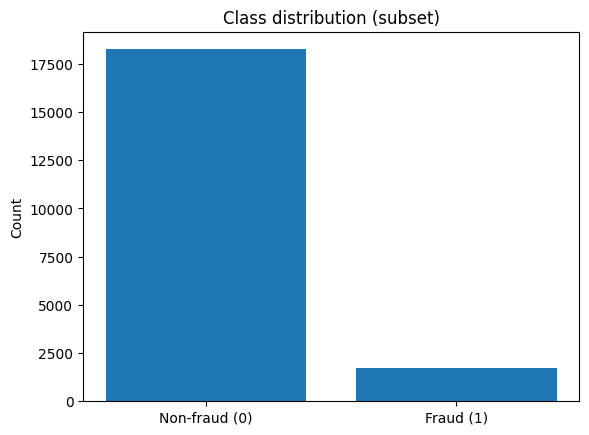

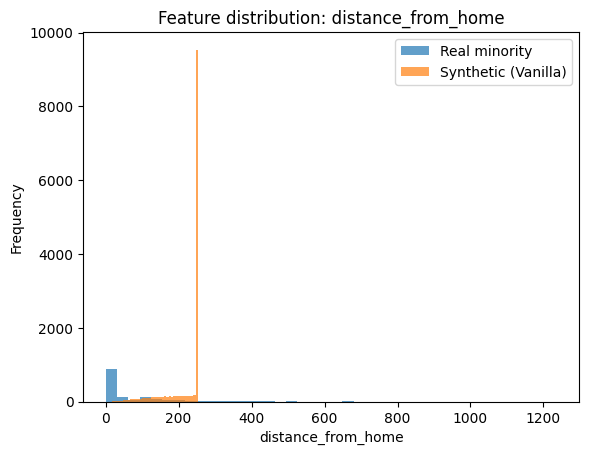

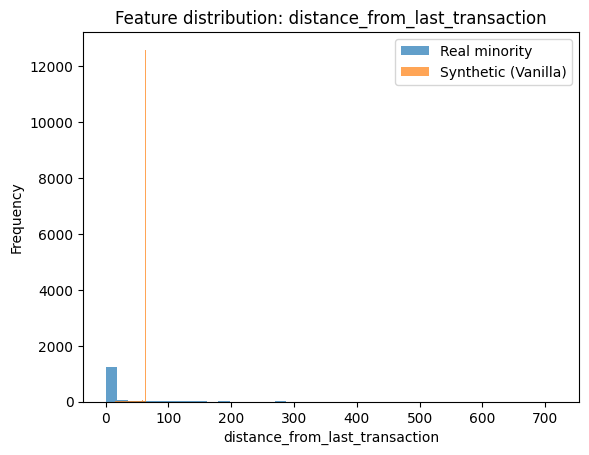

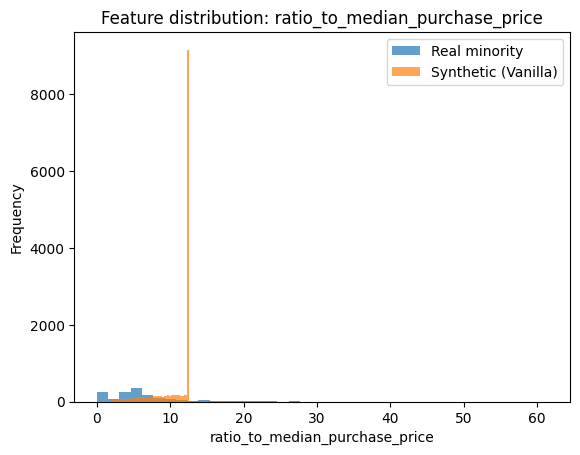

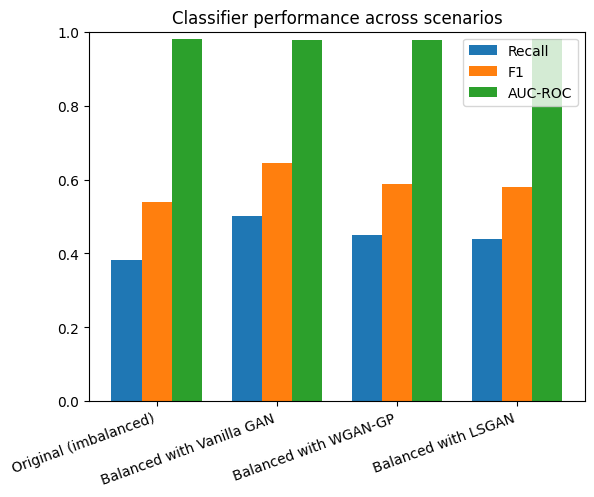

In [10]:
plt.figure()
vc = pd.Series(y).value_counts().sort_index()
plt.bar(["Non-fraud (0)", "Fraud (1)"], vc.values)
plt.title("Class distribution (subset)")
plt.ylabel("Count")
plt.show()

real_min_raw = X_train[y_train==1].values

for i, feat in enumerate(cont_cols):
    plt.figure()
    plt.hist(real_min_raw[:, i], bins=40, alpha=0.7, label="Real minority")
    plt.hist(fake_v_raw[:, i], bins=40, alpha=0.7, label="Synthetic (Vanilla)")
    plt.title(f"Feature distribution: {feat}")
    plt.xlabel(feat); plt.ylabel("Frequency")
    plt.legend()
    plt.show()

plt.figure()
x = np.arange(len(results))
width = 0.25
plt.bar(x - width, results["Recall"], width, label="Recall")
plt.bar(x, results["F1"], width, label="F1")
plt.bar(x + width, results["AUC-ROC"], width, label="AUC-ROC")
plt.xticks(x, results["Scenario"], rotation=20, ha="right")
plt.ylim(0,1)
plt.title("Classifier performance across scenarios")
plt.legend()
plt.show()


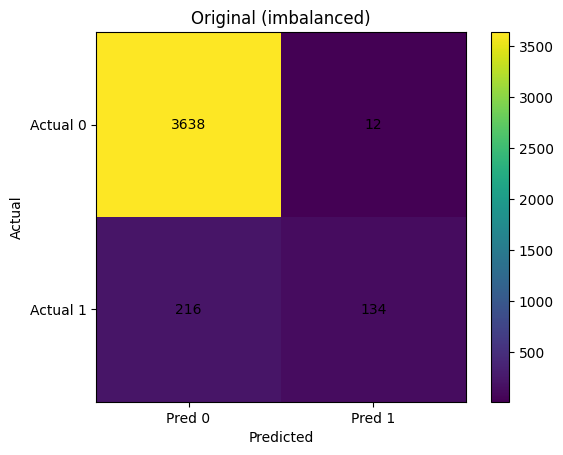

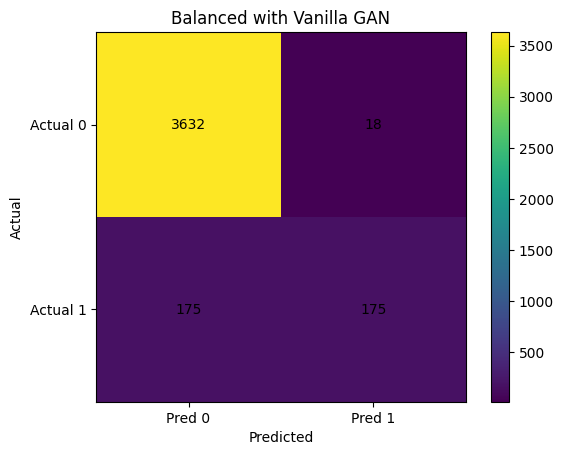

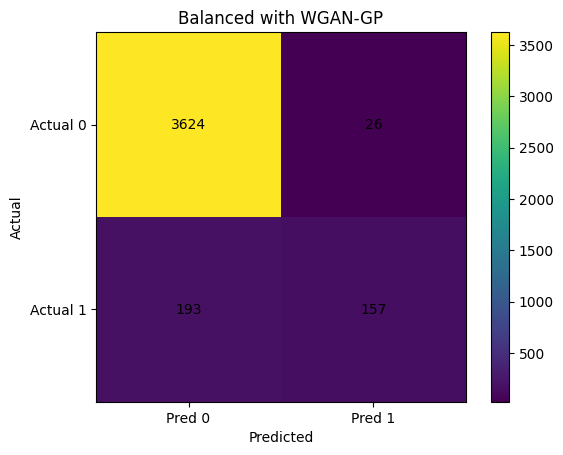

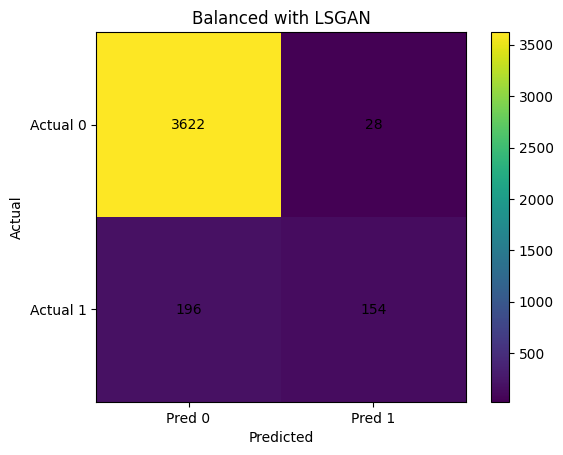

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cm(name, cm):
    plt.figure()
    plt.imshow(cm)
    plt.title(name)
    plt.xticks([0,1], ["Pred 0", "Pred 1"])
    plt.yticks([0,1], ["Actual 0", "Actual 1"])

    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.colorbar()
    plt.show()

plot_cm("Original (imbalanced)", res_base["cm"])
plot_cm("Balanced with Vanilla GAN", res_v["cm"])
plot_cm("Balanced with WGAN-GP", res_w["cm"])
plot_cm("Balanced with LSGAN", res_ls["cm"])



In [14]:
import os
import matplotlib.pyplot as plt
import numpy as np

OUT_DIR = "figures"
os.makedirs(OUT_DIR, exist_ok=True)

def save_cm_heatmap(name, cm, filename):
    plt.figure()
    plt.imshow(cm)  # default colors
    plt.title(name)
    plt.xticks([0,1], ["Pred 0", "Pred 1"])
    plt.yticks([0,1], ["Actual 0", "Actual 1"])

    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, filename), dpi=200)
    plt.close()

save_cm_heatmap("Original (imbalanced)", res_base["cm"], "cm_original.png")
save_cm_heatmap("Balanced with Vanilla GAN", res_v["cm"], "cm_vanilla.png")
save_cm_heatmap("Balanced with WGAN-GP", res_w["cm"], "cm_wgan_gp.png")
save_cm_heatmap("Balanced with LSGAN", res_ls["cm"], "cm_lsgan.png")

print("Saved to:", OUT_DIR)


Saved to: figures


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt

OUT_DIR = "figures"
os.makedirs(OUT_DIR, exist_ok=True)

plt.figure()
x = np.arange(len(results))
width = 0.25

plt.bar(x - width, results["Recall"], width, label="Recall")
plt.bar(x, results["F1"], width, label="F1")
plt.bar(x + width, results["AUC-ROC"], width, label="AUC-ROC")

plt.xticks(x, results["Scenario"], rotation=20, ha="right")
plt.ylim(0, 1)
plt.title("Performance comparison across scenarios")
plt.legend()
plt.tight_layout()

save_path = os.path.join(OUT_DIR, "metrics_comparison.png")
plt.savefig(save_path, dpi=200, bbox_inches="tight")
plt.close()

print("Saved:", save_path)


Saved: figures/metrics_comparison.png


In [16]:
import os
import matplotlib.pyplot as plt

OUT_DIR = "figures"
os.makedirs(OUT_DIR, exist_ok=True)

try:
    cont_cols
except NameError:
    cont_cols = ["distance_from_home", "distance_from_last_transaction", "ratio_to_median_purchase_price"]

def save_feature_distributions(real_min_df, synthetic_array, feature_list, prefix):
    for feat in feature_list:
        i = real_min_df.columns.get_loc(feat)

        plt.figure()
        plt.hist(real_min_df[feat].values, bins=40, alpha=0.7, label="Real minority")
        plt.hist(synthetic_array[:, i], bins=40, alpha=0.7, label=f"Synthetic ({prefix})")
        plt.title(f"Feature distribution: {feat} (Real vs {prefix})")
        plt.xlabel(feat)
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()

        filename = f"dist_{prefix}_{feat}.png".replace("/", "_")
        plt.savefig(os.path.join(OUT_DIR, filename), dpi=200, bbox_inches="tight")
        plt.close()

real_min_df = X_train[y_train == 1].copy()

save_feature_distributions(real_min_df, fake_v_raw, cont_cols, "vanilla")
save_feature_distributions(real_min_df, fake_w_raw, cont_cols, "wgan_gp")
save_feature_distributions(real_min_df, fake_ls_raw, cont_cols, "lsgan")

print("Saved distribution plots to:", OUT_DIR)


Saved distribution plots to: figures
